In [54]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [51]:
np.random.seed(1)
BASIC_ARGS = """
--exp_name test
--grid_size 6
--n_objects 3
--n_colours 3
"""
args = parse_args_str(PARSER, BASIC_ARGS)
print(args.exp_name)

init_start_pos = np.random.randint(0, args.grid_size, size=(args.n_query, 2)).tolist()
print('start positions: ', init_start_pos)

# ow, P_a, rewards_gt, values_gt, policy_gt, feat_map = init_object_world(args)

test
start positions:  [[5, 3]]


## Maxent

In [ ]:
MAXENT_ARGS = """
--exp_name maxent_rand
--type object
--n_objects 3
--n_colours 3
--height 6
--width 6
--gamma 0.8
--act_random 0.3
--n_trajs 5
--l_traj 6
--learning_rate 0.1
--n_iters 10
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--active
"""
args = parse_args_str(PARSER, MAXENT_ARGS)
print(args.exp_name)

history_maxent_active = run_maxent_irl(args, init_start_pos=init_start_pos)

In [ ]:
visualizer = Visualizer(history_maxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

---

## Deep Maxent

In [ ]:
init_start_pos

In [56]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 3
--n_colours 3
--height 6
--width 6
--gamma 0.8
--act_random 0.3
--n_trajs 10
--l_traj 6
--learning_rate 0.001
--n_iters 25
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 1.0
--weight_decay 0.5
--hiddens 16 16
--device cuda
--active
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=init_start_pos)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
[INFO - n_trajs:1] Training Deep MaxEnt IRL


  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:1--
[[-0.0038  0.0057  0.2735  0.3816  0.4991  0.8797]
 [-0.7735 -0.4686 -0.1305 -0.2304 -0.2147  0.2958]
 [-0.3942 -0.4402 -0.2785 -0.6192 -1.     -0.1092]
 [-0.1256 -0.479  -0.5162 -0.5894 -0.5095  0.0382]
 [-0.0049 -0.6163 -0.4325 -0.2579  0.0061  0.4691]
 [ 0.496   0.1586  0.0944  0.2679  0.5757  1.    ]]
[INFO - n_trajs:1] Policy evaluation
-- evd = 1.172781 ---
[INFO - n_trajs:1] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:1--
[[3.8976 4.481  4.4767 4.2287 3.6843 2.7831]
 [4.7473 5.0631 4.9244 4.5848 4.0704 3.3673]
 [5.0196 5.5887 5.4476 5.1255 4.6041 3.9635]
 [4.6154 5.4079 5.5364 5.0742 4.354  3.7069]
 [3.938  4.7281 4.9152 4.4845 3.9532 3.2873]
 [3.2135 4.1918 4.442  3.9509 3.4518 2.669 ]]
[INFO - n_trajs:1] Generating a new demonstrations from [(2, 1)]
Visitation Frequency
[[0 0 1 1 0 0]
 [0 1 1 1 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 2 0]
 [0 0 0 2 2 0]]
[INFO - n_trajs:2] Training Deep MaxEnt IRL


  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:2--
[[ 0.4907  0.4269  0.5279  0.5169  0.5425  0.8166]
 [-0.2013 -0.0265  0.1174 -0.0812 -0.173   0.2482]
 [-0.015  -0.1243 -0.1003 -0.481  -1.     -0.1165]
 [ 0.0819 -0.3048 -0.3294 -0.4064 -0.3967  0.0792]
 [ 0.0667 -0.576  -0.3113 -0.076   0.1407  0.5187]
 [ 0.4838  0.1415  0.1654  0.4055  0.6661  1.    ]]
[INFO - n_trajs:2] Policy evaluation
-- evd = 1.253716 ---
[INFO - n_trajs:2] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:2--
[[3.8357 4.6855 4.8291 4.6886 4.2186 3.2369]
 [4.6538 5.1602 5.1582 4.9507 4.5334 3.827 ]
 [5.1564 5.5832 5.5141 5.346  5.0005 4.3471]
 [5.0597 5.6223 5.7164 5.3542 4.6936 4.0331]
 [4.5046 5.1838 5.2381 4.8346 4.3451 3.679 ]
 [3.6034 4.5204 4.6549 4.299  3.8736 3.0438]]
[INFO - n_trajs:2] Generating a new demonstrations from [(3, 2)]
Visitation Frequency
[[0 0 1 1 0 0]
 [0 1 1 1 0 0]
 [0 1 0 0 0 0]
 [1 2 1 0 0 0]
 [0 1 1 0 2 0]
 [0 0 0 2 2 0]]
[INFO - n_trajs:3] Training Deep MaxEnt IRL


  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:3--
[[ 2.838e-01  4.165e-01  7.141e-01  6.687e-01  6.705e-01  1.000e+00]
 [-6.432e-01 -3.017e-01  5.220e-02 -2.336e-01 -2.436e-01  2.317e-01]
 [-7.550e-01 -7.743e-01 -6.275e-01 -8.941e-01 -1.000e+00 -1.886e-01]
 [-8.334e-01 -9.152e-01 -8.179e-01 -9.355e-01 -7.509e-01 -1.410e-01]
 [-4.962e-01 -8.136e-01 -6.538e-01 -5.936e-01 -3.194e-01  2.109e-01]
 [ 1.822e-01  3.820e-02 -7.940e-02 -7.000e-04  2.630e-01  7.294e-01]]
[INFO - n_trajs:3] Policy evaluation
-- evd = 1.235509 ---
[INFO - n_trajs:3] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:3--
[[3.9156 4.5945 4.7227 4.6953 4.3694 3.4467]
 [4.5834 4.9661 4.9665 4.9427 4.7163 4.0906]
 [5.08   5.3664 5.2628 5.2965 5.131  4.5963]
 [5.1862 5.6928 5.7644 5.696  5.3484 4.7957]
 [4.643  5.3069 5.523  5.3829 4.9992 4.3768]
 [3.8445 4.7283 5.0043 4.8391 4.3981 3.5411]]
[INFO - n_trajs:3] Generating a new demonstrations from [(3, 2)]
Visitation Frequency
[[0 0 1 1 0 0]
 [0 1 1 1 0 0]
 [

  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:4--
[[ 1.      0.7029  0.5872  0.4607  0.4795  0.795 ]
 [ 0.5472  0.1822  0.039  -0.2562 -0.2842  0.163 ]
 [ 0.3063 -0.1276 -0.3564 -0.7296 -1.     -0.2157]
 [ 0.272  -0.1578 -0.4351 -0.6737 -0.63   -0.1207]
 [ 0.5298  0.0575 -0.1766 -0.2925 -0.1461  0.2637]
 [ 0.9848  0.6443  0.3636  0.2772  0.4249  0.7797]]
[INFO - n_trajs:4] Policy evaluation
-- evd = 1.432753 ---
[INFO - n_trajs:4] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:4--
[[3.7517 4.5862 4.8643 4.8836 4.554  3.6126]
 [4.5614 5.1326 5.2967 5.2761 4.9985 4.3259]
 [4.9623 5.4537 5.6081 5.6452 5.4304 4.8139]
 [4.978  5.4875 5.7081 5.7492 5.4358 4.8235]
 [4.5257 5.1112 5.3967 5.4407 5.1038 4.4166]
 [3.6733 4.4956 4.8692 4.9605 4.5811 3.6523]]
[INFO - n_trajs:4] Generating a new demonstrations from [(3, 3)]
Visitation Frequency
[[0 0 1 1 0 0]
 [0 1 1 1 0 0]
 [0 2 1 1 0 0]
 [1 5 5 2 0 0]
 [0 1 1 0 2 0]
 [0 0 0 2 2 0]]
[INFO - n_trajs:5] Training Deep MaxEnt IRL


  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:5--
[[ 0.5051  0.4884  0.6919  0.6728  0.694   0.9966]
 [-0.3634 -0.132   0.1368 -0.1112 -0.1474  0.3283]
 [-0.2803 -0.3884 -0.3028 -0.6934 -1.     -0.0788]
 [-0.1516 -0.4614 -0.5025 -0.6703 -0.562   0.0366]
 [ 0.1272 -0.4516 -0.3133 -0.2539 -0.0115  0.4648]
 [ 0.7457  0.477   0.3182  0.3775  0.6095  1.    ]]
[INFO - n_trajs:5] Policy evaluation
-- evd = 1.293047 ---
[INFO - n_trajs:5] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:5--
[[3.6259 4.3863 4.4748 4.3707 3.9165 2.9362]
 [4.2059 4.6141 4.5021 4.3633 4.0463 3.3729]
 [4.8554 5.141  4.8288 4.7089 4.4715 3.9107]
 [4.4762 5.1973 5.3052 5.0599 4.4735 3.8805]
 [3.7055 4.4567 4.7919 4.6051 4.1265 3.4687]
 [3.1033 4.0651 4.5165 4.2792 3.7277 2.8676]]
[INFO - n_trajs:5] Generating a new demonstrations from [(3, 2)]
Visitation Frequency
[[0 0 1 1 0 0]
 [0 1 1 1 0 0]
 [0 2 1 1 0 0]
 [1 5 6 3 1 0]
 [0 1 1 0 4 1]
 [0 0 0 2 2 0]]
[INFO - n_trajs:6] Training Deep MaxEnt IRL


  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:6--
[[ 0.1608  0.2547  0.4737  0.6282  0.7887  1.    ]
 [-0.518  -0.0881  0.2555  0.4113  0.5861  0.8327]
 [-0.2334 -0.1162  0.1712  0.2426  0.372   0.6722]
 [-0.1057 -0.3901 -0.1855  0.0957  0.3403  0.6336]
 [-0.2114 -1.     -0.362   0.1051  0.4202  0.7097]
 [ 0.1909 -0.1565  0.0023  0.3233  0.6279  0.8904]]
[INFO - n_trajs:6] Policy evaluation
-- evd = 1.020984 ---
[INFO - n_trajs:6] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:6--
[[4.2769 4.9545 5.1183 5.1132 4.8885 4.1088]
 [5.1229 5.531  5.6632 5.6719 5.4989 4.9203]
 [5.3859 5.7718 5.8486 5.8625 5.7166 5.1969]
 [5.3275 5.7941 5.8304 5.8301 5.7101 5.2132]
 [4.9725 5.585  5.5888 5.562  5.4443 4.9188]
 [4.0775 4.9087 5.0103 4.9523 4.7728 4.0497]]
[INFO - n_trajs:6] Generating a new demonstrations from [(2, 3)]
Visitation Frequency
[[0 0 1 1 0 0]
 [0 1 1 1 0 0]
 [0 2 2 5 1 0]
 [1 5 6 3 1 0]
 [0 1 1 0 4 1]
 [0 0 0 2 2 0]]
[INFO - n_trajs:7] Training Deep MaxEnt IRL


  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:7--
[[ 0.7494  0.1067 -0.6415 -0.7585 -0.4065  0.0891]
 [ 0.7898  0.1965 -0.8172 -0.8339 -0.5486  0.0154]
 [ 1.      0.229  -0.7162 -0.8692 -1.     -0.3029]
 [ 0.6999 -0.2091 -0.8876 -0.912  -0.7578 -0.2923]
 [ 0.3401 -0.6962 -0.8239 -0.712  -0.4815 -0.092 ]
 [ 0.383  -0.3464 -0.4605 -0.3598 -0.1403  0.1919]]
[INFO - n_trajs:7] Policy evaluation
-- evd = 1.301325 ---
[INFO - n_trajs:7] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:7--
[[4.342  5.1074 5.3923 5.4497 5.1963 4.3942]
 [5.1022 5.6976 5.9348 6.0079 5.8047 5.1659]
 [5.288  5.8582 6.0936 6.1766 6.0031 5.4061]
 [5.2982 5.879  6.1276 6.1832 6.0025 5.4113]
 [5.121  5.7483 5.993  6.0084 5.8026 5.1737]
 [4.3673 5.1662 5.4284 5.4264 5.1788 4.3851]]
[INFO - n_trajs:7] Generating a new demonstrations from [(3, 3)]
Visitation Frequency
[[0 0 1 1 0 0]
 [0 1 1 1 0 0]
 [0 2 2 5 1 0]
 [1 5 6 5 1 0]
 [0 1 1 3 4 1]
 [0 0 0 3 2 0]]
[INFO - n_trajs:8] Training Deep MaxEnt IRL


  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:8--
[[ 0.1264  0.1916  0.4039  0.5505  0.7131  1.    ]
 [-0.5457 -0.1745  0.1358  0.2201  0.3432  0.7098]
 [-0.2631 -0.1885  0.0525 -0.0088 -0.1176  0.4518]
 [-0.2154 -0.4987 -0.3175 -0.0918  0.0944  0.4944]
 [-0.3797 -1.     -0.4858 -0.0043  0.341   0.7056]
 [-0.0598 -0.3315 -0.1477  0.2685  0.6267  0.9681]]
[INFO - n_trajs:8] Policy evaluation
-- evd = 0.912518 ---
[INFO - n_trajs:8] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:8--
[[3.8303 4.2988 4.3601 4.2449 3.9143 3.1682]
 [4.5956 4.8146 4.8797 4.7701 4.4449 3.9243]
 [5.076  5.1886 5.1654 5.1236 4.828  4.3901]
 [5.0812 5.2671 5.0804 5.0139 4.7771 4.4379]
 [4.7102 4.9938 4.4381 4.3306 4.2884 3.9392]
 [3.7571 4.1444 3.5748 3.5368 3.5708 3.0522]]
[INFO - n_trajs:8] Generating a new demonstrations from [(3, 1)]
Visitation Frequency
[[0 0 1 1 0 0]
 [0 1 1 1 0 0]
 [0 3 3 6 1 0]
 [1 6 7 6 1 0]
 [0 1 1 3 4 1]
 [0 0 0 3 2 0]]
[INFO - n_trajs:9] Training Deep MaxEnt IRL


  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:9--
[[-0.4112 -0.2695  0.1273  0.3995  0.6446  1.    ]
 [-1.     -0.5674 -0.0588  0.0992  0.3099  0.7463]
 [-0.501  -0.3567 -0.0072 -0.0953 -0.1457  0.4631]
 [-0.1538 -0.3255 -0.2441 -0.1821  0.0239  0.4723]
 [-0.0552 -0.4552 -0.22   -0.0264  0.2631  0.6529]
 [ 0.3259  0.1642  0.1518  0.307   0.5679  0.9046]]
[INFO - n_trajs:9] Policy evaluation
-- evd = 1.007608 ---
[INFO - n_trajs:9] Calculating the acqusition map
-- Acquisition Function Map when n_trajs:9--
[[4.161  4.4424 4.5021 4.4388 4.186  3.4761]
 [5.0435 5.1701 5.2396 5.1158 4.8081 4.3042]
 [5.1646 5.5997 5.7125 5.5867 5.2151 4.7253]
 [5.0527 5.7162 5.8098 5.6177 5.2731 4.8287]
 [4.6439 5.347  5.4596 5.2438 4.9531 4.4569]
 [3.8676 4.7437 4.894  4.6522 4.3223 3.5882]]
[INFO - n_trajs:9] Generating a new demonstrations from [(3, 2)]
Visitation Frequency
[[ 0  0  1  1  0  0]
 [ 0  1  1  1  0  0]
 [ 0  3  4  6  1  0]
 [ 1  6 10  8  1  0]
 [ 0  1  1  3  4  1]
 [ 0  0  0  3  2  0]]
[INFO - n_tra

  0%|          | 0/25 [00:00<?, ?it/s]

--Reward Map (Recovered) when n_trajs:10--
[[-7.372e-01 -3.783e-01 -1.056e-01 -1.272e-01 -1.236e-01 -2.362e-01]
 [-1.000e+00 -3.585e-01  1.370e-02  5.090e-02  3.064e-01  1.139e-01]
 [-7.054e-01 -3.288e-01 -4.370e-02  9.680e-02  1.000e+00  3.198e-01]
 [-4.615e-01 -2.465e-01  1.620e-02 -2.890e-02  1.284e-01 -3.000e-03]
 [-2.338e-01 -2.232e-01  1.200e-02  2.000e-04 -1.790e-01 -3.367e-01]
 [ 5.980e-02  2.071e-01  1.363e-01  3.880e-02 -1.676e-01 -4.349e-01]]
[INFO - n_trajs:10] Policy evaluation
-- evd = 1.177534 ---


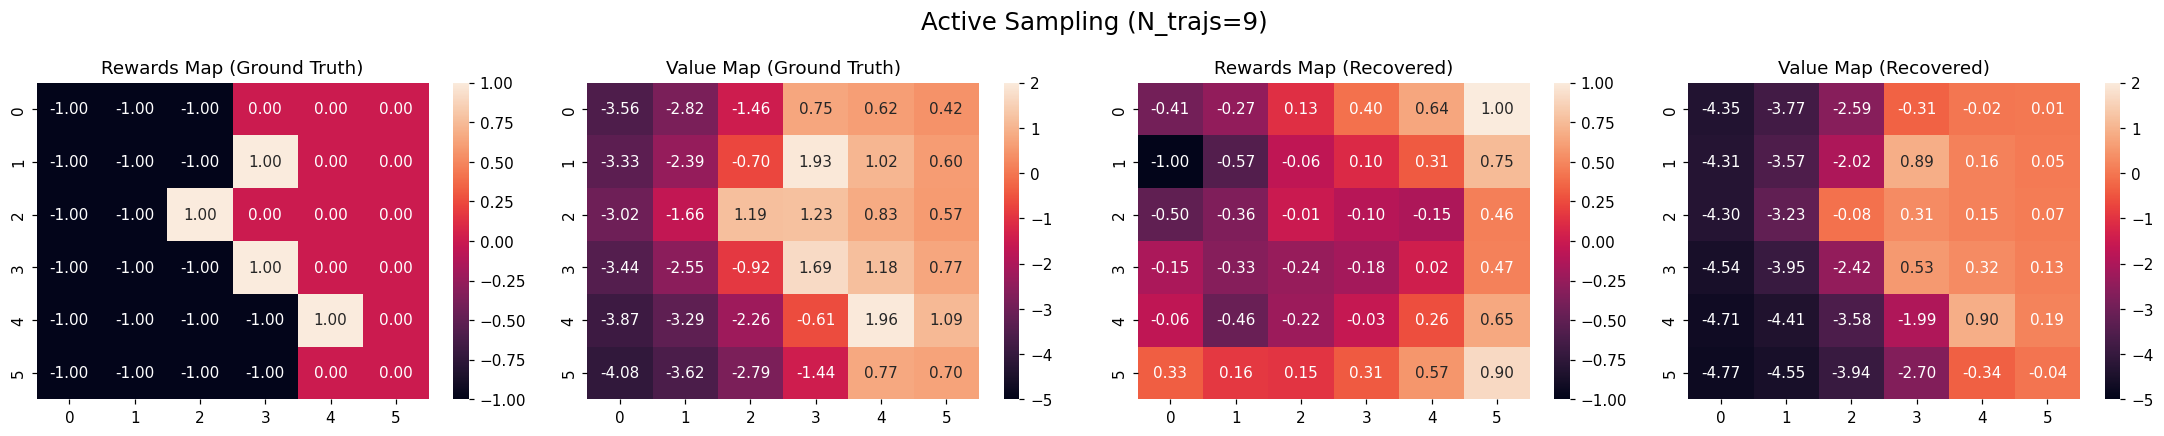

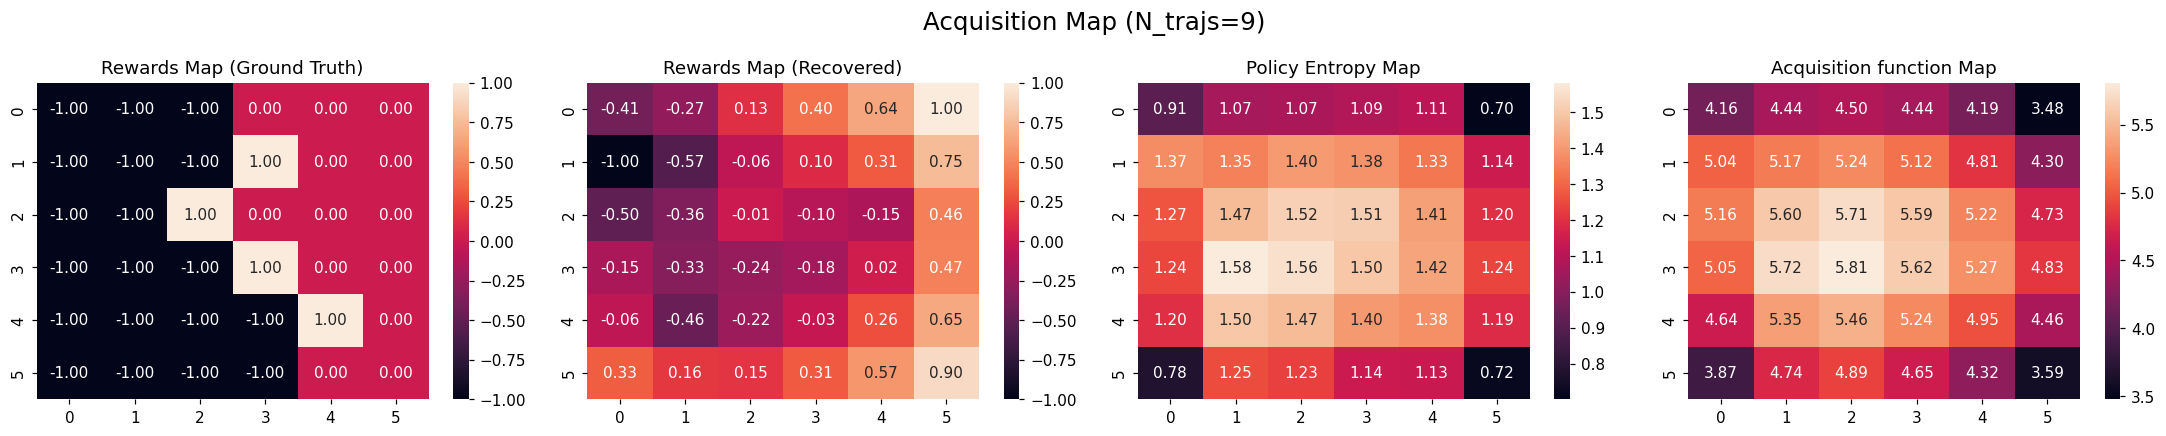

In [57]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)